In [131]:
import numpy as np
import pandas as pd
import hvplot.pandas

In [132]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [133]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('data/pfizer_sentiment_analysis.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(["positive", "negative","neutral"], axis=1)
df = df.resample('D').mean()
df.head()

,compound
date,
2020-01-01,-0.86250
2020-01-02,0.04029
2020-01-03,-0.02382
2020-01-04,-0.22940
2020-01-05,0.14800


In [134]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('data/pfizer_closing_prices.csv', index_col="index", infer_datetime_format=True, parse_dates=True)
df2.head()

,PFE
index,
2020-01-02,39.14
2020-01-03,38.92
2020-01-06,38.87
2020-01-07,38.76
2020-01-08,39.05


In [135]:
# Join the data into a single DataFrame
df = pd.concat([df,df2], axis =1)
df = df.dropna()
df.head()

,compound,PFE
2020-01-02,0.040290,39.14
2020-01-03,-0.023820,38.92
2020-01-06,-0.070842,38.87
2020-01-07,0.086780,38.76
2020-01-08,0.135414,39.05


In [136]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [137]:
# Predict Closing Prices using a 10 day window of previous fng values
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 5

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [138]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [139]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
# YOUR CODE HERE!
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [140]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [141]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [142]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 10
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [143]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [144]:
# Summarize the model
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 5, 10)             480       
_________________________________________________________________
dropout_18 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 5, 10)             840       
_________________________________________________________________
dropout_19 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 10)                840       
_________________________________________________________________
dropout_20 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [145]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=10, verbose=1)

Epoch 1/10
16/16 [==============================] - 0s 6ms/step - loss: 0.3490
Epoch 2/10
16/16 [==============================] - 0s 5ms/step - loss: 0.2279
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.1116
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0622
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0657
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0583
Epoch 7/10
16/16 [==============================] - 0s 5ms/step - loss: 0.0550
Epoch 8/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0616
Epoch 9/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0578
Epoch 10/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0584


---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [146]:
# Evaluate the model
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 1ms/step - loss: 0.0190


0.018967043608427048

In [147]:
# Make some predictions
predicted = model.predict(X_test)

In [148]:
# Recover the original prices instead of the scaled version

predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [149]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2020-08-17,38.06,36.203716
2020-08-18,38.36,36.230858
2020-08-19,38.36,35.951782
2020-08-20,38.26,35.710403
2020-08-21,38.73,35.633057


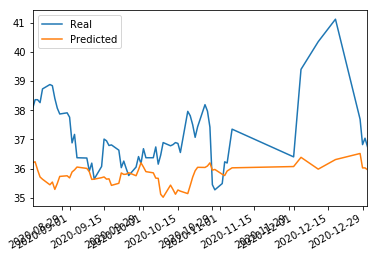

In [150]:
# Plot the real vs predicted values as a line chart
stocks.plot()